In [ ]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


In [1]:
from pathlib import Path
import glob
import itertools
import lmdb
import h5py
import os
import sys
import time
import datetime
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
###%matplotlib inline

from nilearn import signal,image,masking
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
from keras.utils import np_utils

import lmdb
import tensorflow as tf
from tensorpack import dataflow
from tensorpack.utils.serialize import dumps, loads

try:
    # import cnn_graph
    from cnn_graph.lib import models, graph, coarsening, utils
except ImportError:
    print('Could not find the package of graph-cnn ...')
    print('Please check the location where cnn_graph is !\n')


/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [2]:
pathdata = '/home/yu/PycharmProjects/HCP_data/'
pathout = pathdata + "temp_res_new/"

modality = 'WM' #'MOTOR'
###dict for different types of movement
motor_task_con = {"rf": "foot_mot",
                  "lf": "foot_mot",
                  "rh": "hand_mot",
                  "lh": "hand_mot",
                  "t": "tongue_mot"}
wm_task_con   =  {"2bk_body":   "body2b_wm",
                  "2bk_faces":  "face2b_wm",
                  "2bk_places": "place2b_wm",
                  "2bk_tools":  "tool2b_wm",
                  "0bk_body":   "body0b_wm",
                  "0bk_faces":  "face0b_wm",
                  "0bk_places": "place0b_wm",
                  "0bk_tools":  "tool0b_wm"}

task_contrasts = wm_task_con #motor_task_con
target_name = np.unique(pd.Series(list(task_contrasts.values())))
#target_name = np.unique(pd.Series(list(task_contrasts.values())).str.split('_',expand = True)[0])
print(target_name)

mmp_atlas = pathdata + "HCP_S1200_GroupAvg_v1/"+"Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii"
AtlasName = 'MMP'
block_dura = 1
TR = 0.72

##############################################
#####start collecting data for classification algorithm
EVS_files = []
pathfmri = Path(pathdata + 'aws_s3_HCP1200/FMRI/')
for ev in pathfmri.glob('tfMRI_' + modality + '_??/*combined_events_spm_' + modality + '.csv'):
   EVS_files.append(str(ev))

ev_filename = "_event_labels_1200R_LR_RL_new.txt"
events_all_subjects_file = pathout+modality+ev_filename
if os.path.isfile(events_all_subjects_file):
    trial_infos = pd.read_csv(EVS_files[0],sep="\t",encoding="utf8",header = None,names=['onset','duration','rep','task'])
    Duras = np.ceil((trial_infos.duration/TR)).astype(int) #(trial_infos.duration/TR).astype(int)

    print('Collecting trial info from file:', events_all_subjects_file)
    subjects_trial_labels = pd.read_csv(events_all_subjects_file,sep="\t",encoding="utf8")
    ###print(subjects_trial_labels.keys())

    subjects_trial_label_matrix = subjects_trial_labels.values.tolist()
    trialID = subjects_trial_labels['trialID']
    sub_name = subjects_trial_labels['subject'].tolist()
    coding_direct = subjects_trial_labels['coding']
    print(np.array(subjects_trial_label_matrix).shape,len(sub_name),len(np.unique(sub_name)),len(coding_direct))

Trial_dura = np.unique(Duras)[0]

print('each trial contains %d volumes/TRs for task %s' % (Trial_dura,modality))
print('Collecting event design files for subjects and saved into matrix ...\n' , np.array(subjects_trial_label_matrix).shape)

['body0b_wm' 'body2b_wm' 'face0b_wm' 'face2b_wm' 'place0b_wm' 'place2b_wm'
 'tool0b_wm' 'tool2b_wm']


(2148, 408) 2148 1079 2148
each trial contains 39 volumes/TRs for task WM
 (2148, 408)


In [3]:
from tensorpack.utils.serialize import dumps, loads
import lmdb
lmdb_filename = pathout+modality+"_MMP_ROI_act_1200R_test_Dec2018_ALL.lmdb"

## read lmdb matrix
print('loading data from file: %s' % lmdb_filename)
matrix_dict = []
fmri_sub_name = []
lmdb_env = lmdb.open(lmdb_filename, subdir=False)
try:
    lmdb_txn = lmdb_env.begin()
    listed_fmri_files = loads(lmdb_txn.get(b'__keys__'))
    listed_fmri_files = [l.decode("utf-8") for l in listed_fmri_files]
    print('Stored fmri data from files:')
    print(len(listed_fmri_files))
except:
    print('Search each key for every fmri file...')

with lmdb_env.begin() as lmdb_txn:
    cursor = lmdb_txn.cursor()
    for key, value in cursor:
        #print(key)
        if key == b'__keys__':
            continue
        pathsub = Path(os.path.dirname(key.decode("utf-8")))
        if any('REST' in string for string in lmdb_filename.split('_')):
            fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-2][-1] + '_' + pathsub.parts[-1].split('_')[-1])
        else:
            #fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-1])
            subname_info = os.path.basename(key.decode("utf-8")).split('_')
            fmri_sub_name.append('_'.join((subname_info[0],subname_info[2],subname_info[3])))
        data = loads(lmdb_txn.get(key)).astype('float32', casting='same_kind')
        if any('REST' in string for string in lmdb_filename.split('_')):
            if data is None or data.shape[0] != Trial_Num:
                print('fmri data shape mis-matching between subjects...')
                print('Check subject:  %s with only %d Trials \n' % (fmri_sub_name[-1], data.shape[0]))
                del fmri_sub_name[-1]
            else:
                matrix_dict.append(np.array(data))
        else:
            matrix_dict.append(np.array(data))
lmdb_env.close()

subjects_tc_matrix = matrix_dict
subname_coding = fmri_sub_name
print(np.array(subjects_tc_matrix).shape)
print(subjects_tc_matrix[0].shape)



loading data from file: /home/yu/PycharmProjects/HCP_data/temp_res_new/WM_MMP_ROI_act_1200R_test_Dec2018_ALL.lmdb
Search each key for every fmri file...


(2149,)
(405, 360)


In [4]:
def preclean_data_for_shape_match(subjects_tc_matrix,subjects_trial_label_matrix, fmri_sub_name, ev_sub_name):
    print("Pre-clean the fmri and event data to make sure the matching shapes between two arrays!")
    Subject_Num = np.array(subjects_tc_matrix).shape[0]
    Trial_Num, Region_Num = subjects_tc_matrix[0].shape
    if len(fmri_sub_name) != len(ev_sub_name):
        print('Warning: Mis-matching subjects list between fmri-data-matrix and trial-label-matrix')
        print(np.array(subjects_tc_matrix).shape,np.array(subjects_trial_label_matrix).shape)
        subj = 0
        if len(fmri_sub_name) > len(ev_sub_name):
            for ev,subcount in zip(ev_sub_name, range(Subject_Num)):
                ###remove fmri files if the event design is missing
                while fmri_sub_name[subj].split('_')[0] < str(ev):
                    print("Event files and fmri data are miss-matching for subject: ")
                    print(ev, ':', fmri_sub_name[subj].split('_')[0])
                    print("Due to missing event files for subject : %s" % fmri_sub_name[subj])
                    del fmri_sub_name[subj]
                    del subjects_tc_matrix[subj]
                    subj += 1
                else:
                    if subj > Subject_Num:
                        ev_sub_name.remove(ev)
                        del subjects_trial_label_matrix[subcount]
                    if fmri_sub_name[subj].split('_')[0] == str(ev): subj += 1
            subjects_trial_label_matrix[subj:] = []
            ev_sub_name[subj:] = []

        elif len(fmri_sub_name) < len(ev_sub_name):
            for fmri_file,subcount in zip(fmri_sub_name, range(len(ev_sub_name))):
                ###remove fmri files if the event design is missing
                while str(ev_sub_name[subj]) < fmri_file.split('_')[0]:
                    print("Event files and fmri data are miss-matching for subject: ")
                    print(ev_sub_name[subj], ':', fmri_file.split('_')[0])
                    print("Due to missing fmri data for subject : %s" % str(ev_sub_name[subj]))
                    del ev_sub_name[subj]
                    del subjects_trial_label_matrix[subj]
                    subj += 1
                else:
                    if subj > len(ev_sub_name):
                        fmri_sub_name.remove(fmri_file)
                        del subjects_tc_matrix[subcount]
                        subj = 0
                    if str(ev_sub_name[subj]) == fmri_file.split('_')[0]: subj += 1
            subjects_tc_matrix[subj:] = []
            fmri_sub_name[subj:] = []

    for subj in range(min(len(fmri_sub_name),len(ev_sub_name))):
        try:
            tsize, rsize = np.array(subjects_tc_matrix[subj]).shape
            tsize2 = len(subjects_trial_label_matrix[subj])
        except:
            print(subj==Subject_Num-1)
            print('The end of SubjectList...\n')
        if tsize != Trial_Num or tsize2 != Trial_Num:
            if tsize2 > Trial_Num:
                ##print('Cut event data for subject %s from %d to fit event label matrix' % (fmri_sub_name[subj],tsize2))
                subjects_trial_label_matrix[subj][Trial_Num:] = [] 
            else:
                print('Remove subject: %s due to different trial num: %d in the fmri data' % (fmri_sub_name[subj],tsize))
                del subjects_tc_matrix[subj]
                del subjects_trial_label_matrix[subj]
            
        if rsize != Region_Num:
            print('Remove subject: %s due to different region num: %d in the fmri data' % (fmri_sub_name[subj],rsize))
            del subjects_tc_matrix[subj]
            del subjects_trial_label_matrix[subj]

    print('Done matching data shapes:',np.array(subjects_tc_matrix).shape,np.array(subjects_trial_label_matrix).shape)
    return subjects_tc_matrix, subjects_trial_label_matrix

subjects_tc_matrix_new, subjects_trial_label_matrix_new = \
    preclean_data_for_shape_match(subjects_tc_matrix,subjects_trial_label_matrix,subname_coding, sub_name)
Subject_Num = np.array(subjects_tc_matrix_new).shape[0]
print(np.array(subjects_trial_label_matrix_new).shape)
print(np.array(subjects_tc_matrix_new).shape)
print(np.unique(subjects_trial_label_matrix_new))

Pre-clean the fmri and event data to make sure the matching shapes between two arrays!
(2149,) (2148, 408)
Event files and fmri data are miss-matching for subject: 
197348 : 196952
Due to missing event files for subject : 196952_WM_LR


Done matching data shapes: (2148, 405, 360) (2148, 405)


(2148, 405)


(2148, 405, 360)
['body0b_wm' 'body2b_wm' 'face0b_wm' 'face2b_wm' 'place0b_wm' 'place2b_wm'
 'rest' 'tool0b_wm' 'tool2b_wm']


In [6]:
def subject_cross_validation_split_trials(tc_matrix, label_matrix,target_name, sub_num=None, block_dura=18, n_folds=10, testsize=0.2, valsize=0.1,randomseed=1234):
    ##randomseed=1234;testsize = 0.2;n_folds=10;valsize=0.1
    from sklearn import preprocessing
    from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
    
    Subject_Num, Trial_Num, Region_Num = np.array(tc_matrix).shape
    rs = np.random.RandomState(randomseed)
    if not sub_num or sub_num>Subject_Num:
        sub_num = Subject_Num
    if not block_dura:
        block_dura = 18 ###12s block for MOTOR task

    fmri_data_matrix = []
    label_data_matrix = []
    for subi in range(Subject_Num):
        label_trial_data = np.array(label_matrix[subi])
        condition_mask = pd.Series(label_trial_data).isin(target_name)
        ##condition_mask = pd.Series(label_trial_data).str.split('_', expand=True)[0].isin(target_name)
        fmri_data_matrix.append(tc_matrix[subi][condition_mask, :])
        label_data_matrix.append(label_trial_data[condition_mask])
    fmri_data_matrix = np.array(fmri_data_matrix).astype('float32', casting='same_kind')
    label_data_matrix = np.array(label_data_matrix)
    ##cut the trials into blocks
    chunks = int(np.floor(label_data_matrix.shape[-1] / block_dura))
    fmri_data_block = np.array(np.array_split(fmri_data_matrix, chunks, axis=1)).mean(axis=2).astype('float32',casting='same_kind')
    label_data_block = np.array(np.array_split(label_data_matrix, chunks, axis=1))[:, :, 0]
    print(fmri_data_block.shape,label_data_block.shape)

    train_sid_tmp, test_sid = train_test_split(range(sub_num), test_size=testsize, random_state=rs, shuffle=True)
    fmri_data_train = np.array([fmri_data_block[:, i, :] for i in train_sid_tmp]).astype('float32', casting='same_kind')
    fmri_data_test = np.array([fmri_data_block[:, i, :] for i in test_sid]).astype('float32', casting='same_kind')
    # print(fmri_data_train.shape,fmri_data_test.shape)

    label_data_train = np.array([label_data_block[:, i] for i in train_sid_tmp])
    label_data_test = np.array([label_data_block[:, i] for i in test_sid])
    # print(label_data_train.shape,label_data_test.shape)

    ###transform the data
    scaler = preprocessing.StandardScaler().fit(np.vstack(fmri_data_train))
    ##fmri_data_train = scaler.transform(fmri_data_train)
    X_test = scaler.transform(np.vstack(fmri_data_test))
    nb_class = len(np.unique(label_data_block))
    Y_test = label_data_test.ravel()
    # print(X_test.shape,Y_test.shape)

    from sklearn.model_selection import ShuffleSplit
    valsplit = ShuffleSplit(n_splits=n_folds, test_size=valsize, random_state=rs)
    X_train_scaled = []
    X_val_scaled = []
    Y_train_scaled = []
    Y_val_scaled = []
    for train_sid, val_sid in valsplit.split(train_sid_tmp):
        ##preprocess features and labels
        X = np.array(np.vstack([fmri_data_train[i, :, :] for i in train_sid]))
        Y = np.array([label_data_train[i, :] for i in train_sid]).ravel()
        # print(X.shape, Y.shape)
        X_train_scaled.append(scaler.transform(X))
        Y_train_scaled.append(Y)

        X = np.array(np.vstack([fmri_data_train[i, :, :] for i in val_sid]))
        Y = np.array([label_data_train[i, :] for i in val_sid]).ravel()
        # print(X.shape, Y.shape)
        X_val_scaled.append(scaler.transform(X))
        Y_val_scaled.append(Y)

    print('Samples of Subjects for training: %d and testing %d and validating %d with %d classes' % (
    len(train_sid), len(test_sid), len(val_sid), nb_class))
    return X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test, Y_test

    
##########################################
Subject_Num, Trial_Num, Region_Num = np.array(subjects_tc_matrix_new).shape
if Trial_Num != np.array(subjects_trial_label_matrix_new).shape[1]:
    print('Miss-matching trial infos for event and fmri data')
if Subject_Num != np.array(subjects_trial_label_matrix_new).shape[0]:
    print('Adjust subject numbers for event data')
    subjects_trial_label_matrix = np.array(subjects_trial_label_matrix_new[:Subject_Num])
else:
    subjects_trial_label_matrix = np.array(subjects_trial_label_matrix_new)

    
block_dura = 1
##split data into train, val and test in subject-level
X_train, Y_train, X_val, Y_val, X_test, Y_test = \
subject_cross_validation_split_trials(subjects_tc_matrix_new, subjects_trial_label_matrix,target_name,block_dura=block_dura)

from sklearn import preprocessing
X_train_all = np.array(np.vstack((X_train[0], X_val[0])))
Y_train_all = np.array(np.concatenate((Y_train[0], Y_val[0]), axis=0))
print('sample size for training and testing: ', X_train_all.shape, Y_train_all.shape)
le = preprocessing.LabelEncoder()
le.fit(np.unique(Y_train_all))
Y_train_int = le.transform(Y_train_all)
Y_test_int = le.transform(Y_test)



(312, 2148, 360) (312, 2148)
Samples of Subjects for training: 1546 and testing 430 and validating 172 with 8 classes
sample size for training and testing:  (536016, 360) (536016,)


In [5]:
def subject_cross_validation_split_trials_new(tc_matrix, label_matrix,target_name, sub_num=None, block_dura=18, n_folds=10, testsize=0.2, valsize=0.1,randomseed=1234):
    ##randomseed=1234;testsize = 0.2;n_folds=10;valsize=0.1
    from sklearn import preprocessing
    from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
        
    Subject_Num, Trial_Num, Region_Num = np.array(tc_matrix).shape
    rs = np.random.RandomState(randomseed)
    if not sub_num or sub_num>Subject_Num:
        sub_num = Subject_Num
    if not block_dura:
        block_dura = 18 ###12s block for MOTOR task
        
    global Trial_dura
    print('each trial contains %d volumes/TRs for task %s' % (Trial_dura,modality))
    
    fmri_data_matrix = []
    label_data_matrix = []
    for subi in range(Subject_Num):
        label_trial_data = np.array(label_matrix[subi])
        condition_mask = pd.Series(label_trial_data).isin(target_name)
        ##condition_mask = pd.Series(label_trial_data).str.split('_', expand=True)[0].isin(target_name)
        
        tc_matrix_select = np.array(tc_matrix[subi][condition_mask, :])
        label_data_select = np.array(label_trial_data[condition_mask])
        ##print(tc_matrix_select.shape,label_data_select.shape)
        
        
        le = preprocessing.LabelEncoder()
        le.fit(target_name)
        label_data_int = le.transform(label_data_select)
        
        ##cut the trials
        chunks = int(np.floor(len(label_data_select)/Trial_dura))
        label_data_trial_block = np.array(np.split(label_data_select, np.where(np.diff(label_data_int))[0]+1))
        if label_data_trial_block.shape[0] != chunks:
            print("Wrong cutting of event data...")
            print("Should have %d block-trials but only found %d cuts" % (chunks,label_data_trial_block.shape[0]))   
        label_data_trial_block = np.array([label_data_trial_block[i][:Trial_dura] for i in range(chunks)]) 
    
        fmri_data_block = np.array_split(tc_matrix_select,np.where(np.diff(label_data_int))[0]+1,axis=0)
        fmri_data_block = np.array([fmri_data_block[i][:Trial_dura,:] for i in range(chunks)])
        if subi==1: print('first cut:',fmri_data_block.shape,label_data_trial_block.shape)
        
        ##cut each trial to blocks
        chunks = int(np.ceil(Trial_dura / block_dura))
        if Trial_dura % block_dura:
            fmri_data_block = np.array(np.vstack(np.array_split(fmri_data_block, chunks, axis=1)[:-1])).mean(axis=1).astype('float32',casting='same_kind')
            label_data_trial_block = np.array(np.vstack(np.array_split(label_data_trial_block, chunks, axis=1)[:-1]))[:,0]
        else:
            fmri_data_block = np.array(np.vstack(np.array_split(fmri_data_block, chunks, axis=1))).mean(axis=1).astype('float32',casting='same_kind')
            label_data_trial_block = np.array(np.vstack(np.array_split(label_data_trial_block, chunks, axis=1)))[:,0]
        if subi==1: print('second cut:',fmri_data_block.shape,label_data_trial_block.shape)    
        ##label_data_test = le.transform(label_data_trial_block[:,0]).flatten()
        if subi==1: print('finalize: reshape data into size:',fmri_data_block.shape,label_data_trial_block.shape)
       
        fmri_data_matrix.append(fmri_data_block)
        label_data_matrix.append(label_data_trial_block)
    fmri_data_matrix = np.array(fmri_data_matrix).astype('float32', casting='same_kind')
    label_data_matrix = np.array(label_data_matrix)
    print(fmri_data_matrix.shape,label_data_matrix.shape)
    
    
    ########spliting into train,val and testing
    train_sid_tmp, test_sid = train_test_split(range(sub_num), test_size=testsize, random_state=rs, shuffle=True)
    fmri_data_train = np.array([fmri_data_matrix[i] for i in train_sid_tmp]).astype('float32', casting='same_kind')
    fmri_data_test = np.array([fmri_data_matrix[i] for i in test_sid]).astype('float32', casting='same_kind')
    print('fmri data for train and test:',fmri_data_train.shape,fmri_data_test.shape)
    
    label_data_train = np.array([label_data_matrix[i] for i in train_sid_tmp])
    label_data_test = np.array([label_data_matrix[i] for i in test_sid])
    print('label data for train and test',label_data_train.shape,label_data_test.shape)
    
    ###transform the data
    
    scaler = preprocessing.StandardScaler().fit(np.vstack(fmri_data_train))
    ##fmri_data_train = scaler.transform(fmri_data_train)
    X_test = scaler.transform(np.vstack(fmri_data_test))
    nb_class = len(target_name)
    Y_test = label_data_test.ravel()
    ##print(X_test.shape,Y_test.shape)
    
    from sklearn.model_selection import ShuffleSplit
    valsplit = ShuffleSplit(n_splits=n_folds, test_size=valsize, random_state=rs)
    X_train_scaled = []
    X_val_scaled = []
    Y_train_scaled = []
    Y_val_scaled = []
    for train_sid, val_sid in valsplit.split(train_sid_tmp):
        ##preprocess features and labels
        X = np.array(np.vstack([fmri_data_train[i] for i in train_sid]))
        Y = np.array([label_data_train[i] for i in train_sid]).ravel()
        #print('fmri and label data for training:',X.shape, Y.shape)
        X_train_scaled.append(scaler.transform(X))
        Y_train_scaled.append(Y)
    
        X = np.array(np.vstack([fmri_data_train[i] for i in val_sid]))
        Y = np.array([label_data_train[i] for i in val_sid]).ravel()
        #print('fmri and label data for validation:',X.shape, Y.shape)
        X_val_scaled.append(scaler.transform(X))
        Y_val_scaled.append(Y)
    
    print('Samples of Subjects for training: %d and testing %d and validating %d with %d classes' % (len(train_sid), len(test_sid), len(val_sid), nb_class))
    return X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test, Y_test

    
##########################################
Subject_Num, Trial_Num, Region_Num = np.array(subjects_tc_matrix_new).shape
if Trial_Num != np.array(subjects_trial_label_matrix_new).shape[1]:
    print('Miss-matching trial infos for event and fmri data')
if Subject_Num != np.array(subjects_trial_label_matrix_new).shape[0]:
    print('Adjust subject numbers for event data')
    subjects_trial_label_matrix = np.array(subjects_trial_label_matrix_new[:Subject_Num])
else:
    subjects_trial_label_matrix = np.array(subjects_trial_label_matrix_new)

    
block_dura = 39
Trial_dura = 39
##split data into train, val and test in subject-level
X_train, Y_train, X_val, Y_val, X_test, Y_test = \
subject_cross_validation_split_trials_new(subjects_tc_matrix_new, subjects_trial_label_matrix,target_name,sub_num=100,block_dura=block_dura)

from sklearn import preprocessing
X_train_all = np.array(np.vstack((X_train[0], X_val[0])))
Y_train_all = np.array(np.concatenate((Y_train[0], Y_val[0]), axis=0))
print('sample size for training and testing: ', X_train_all.shape, Y_train_all.shape)
le = preprocessing.LabelEncoder()
le.fit(np.unique(Y_train_all))
Y_train_int = le.transform(Y_train_all)
Y_test_int = le.transform(Y_test)

each trial contains 39 volumes/TRs for task WM
first cut: (8, 39, 360) (8, 39)
second cut: (8, 360) (8,)
finalize: reshape data into size: (8, 360) (8,)


(2148, 8, 360) (2148, 8)
fmri data for train and test: (80, 8, 360) (20, 8, 360)
label data for train and test (80, 8) (20, 8)
Samples of Subjects for training: 72 and testing 20 and validating 8 with 8 classes
sample size for training and testing:  (640, 360) (640,)


In [66]:
tc_matrix = subjects_tc_matrix_new
label_matrix = subjects_trial_label_matrix
sub_num = 100
block_dura = 3
randomseed=1234;testsize = 0.2;n_folds=10;valsize=0.1

Subject_Num, Trial_Num, Region_Num = np.array(tc_matrix).shape
rs = np.random.RandomState(randomseed)
if not sub_num or sub_num>Subject_Num:
    sub_num = Subject_Num
if not block_dura:
    block_dura = 18 ###12s block for MOTOR task
print('each trial contains %d volumes/TRs for task %s' % (Trial_dura,modality))

fmri_data_matrix = []
label_data_matrix = []
for subi in range(Subject_Num):
    label_trial_data = np.array(label_matrix[subi])
    condition_mask = pd.Series(label_trial_data).isin(target_name)
    ##condition_mask = pd.Series(label_trial_data).str.split('_', expand=True)[0].isin(target_name)
    
    tc_matrix_select = np.array(tc_matrix[subi][condition_mask, :])
    label_data_select = np.array(label_trial_data[condition_mask])
    ##print(tc_matrix_select.shape,label_data_select.shape)
    
    
    le = preprocessing.LabelEncoder()
    le.fit(target_name)
    label_data_int = le.transform(label_data_select)
    
    ##cut the trials
    chunks = int(np.floor(len(label_data_select)/Trial_dura))
    label_data_trial_block = np.array(np.split(label_data_select, np.where(np.diff(label_data_int))[0]+1))
    if label_data_trial_block.shape[0] != chunks:
        print("Wrong cutting of event data...")
        print("Should have %d block-trials but only found %d cuts" % (chunks,label_data_trial_block.shape[0]))   
    label_data_trial_block = np.array([label_data_trial_block[i][:Trial_dura] for i in range(chunks)]) 

    fmri_data_block = np.array_split(tc_matrix_select,np.where(np.diff(label_data_int))[0]+1,axis=0)
    fmri_data_block = np.array([fmri_data_block[i][:Trial_dura,:] for i in range(chunks)])
    if subi==1: print('first cut:',fmri_data_block.shape,label_data_trial_block.shape)
    
    ##cut each trial to blocks
    chunks = int(np.ceil(Trial_dura / block_dura))
    if Trial_dura % block_dura:
        fmri_data_block = np.array(np.vstack(np.array_split(fmri_data_block, chunks, axis=1)[:-1])).astype('float32',casting='same_kind')
        label_data_trial_block = np.array(np.vstack(np.array_split(label_data_trial_block, chunks, axis=1)[:-1]))[:,0]
    else:
        fmri_data_block = np.array(np.vstack(np.array_split(fmri_data_block, chunks, axis=1))).astype('float32',casting='same_kind')
        label_data_trial_block = np.array(np.vstack(np.array_split(label_data_trial_block, chunks, axis=1)))[:,0]
    if subi==1: print('second cut:',fmri_data_block.shape,label_data_trial_block.shape)    
    ##label_data_test = le.transform(label_data_trial_block[:,0]).flatten()
    if subi==1: print('finalize: reshape data into size:',fmri_data_block.shape,label_data_trial_block.shape)
   
    fmri_data_matrix.append(fmri_data_block)
    label_data_matrix.append(label_data_trial_block)
fmri_data_matrix = np.array(fmri_data_matrix).astype('float32', casting='same_kind')
label_data_matrix = np.array(label_data_matrix)
print(fmri_data_matrix.shape,label_data_matrix.shape)


########spliting into train,val and testing
fmri_data_matrix = fmri_data_matrix.reshape((Subject_Num,fmri_data_block.shape[0],np.prod(fmri_data_block.shape[1:])))
train_sid_tmp, test_sid = train_test_split(range(sub_num), test_size=testsize, random_state=rs, shuffle=True)
fmri_data_train = np.array([fmri_data_matrix[i] for i in train_sid_tmp]).astype('float32', casting='same_kind')
fmri_data_test = np.array([fmri_data_matrix[i] for i in test_sid]).astype('float32', casting='same_kind')
print('fmri data for train and test:',fmri_data_train.shape,fmri_data_test.shape)

label_data_train = np.array([label_data_matrix[i] for i in train_sid_tmp])
label_data_test = np.array([label_data_matrix[i] for i in test_sid])
print('label data for train and test',label_data_train.shape,label_data_test.shape)

###transform the data

scaler = preprocessing.StandardScaler().fit(np.vstack(fmri_data_train))
##fmri_data_train = scaler.transform(fmri_data_train)
X_test = scaler.transform(np.vstack(fmri_data_test))
nb_class = len(target_name)
Y_test = label_data_test.ravel()
print(X_test.shape,Y_test.shape)

from sklearn.model_selection import ShuffleSplit
valsplit = ShuffleSplit(n_splits=n_folds, test_size=valsize, random_state=rs)
X_train_scaled = []
X_val_scaled = []
Y_train_scaled = []
Y_val_scaled = []
for train_sid, val_sid in valsplit.split(train_sid_tmp):
    ##preprocess features and labels
    X = np.array(np.vstack([fmri_data_train[i] for i in train_sid]))
    Y = np.array([label_data_train[i] for i in train_sid]).ravel()
    #print('fmri and label data for training:',X.shape, Y.shape)
    X_train_scaled.append(scaler.transform(X))
    Y_train_scaled.append(Y)

    X = np.array(np.vstack([fmri_data_train[i] for i in val_sid]))
    Y = np.array([label_data_train[i] for i in val_sid]).ravel()
    #print('fmri and label data for validation:',X.shape, Y.shape)
    X_val_scaled.append(scaler.transform(X))
    Y_val_scaled.append(Y)

#print(list(X_test.shape[:-1])+list(fmri_data_block.shape[1:]))
X_test = X_test.reshape(list(X_test.shape[:-1])+list(fmri_data_block.shape[1:]))
X_train_scaled = np.reshape(X_train_scaled,list(X_train_scaled.shape[:-1])+list(fmri_data_block.shape[1:]))
X_val_scaled = np.reshape(X_val_scaled,list(X_val_scaled.shape[:-1])+list(fmri_data_block.shape[1:]))
print(X_test.shape,np.array(X_train_scaled).shape,np.array(X_val_scaled).shape)
print('Samples of Subjects for training: %d and testing %d and validating %d with %d classes' % (len(train_sid), len(test_sid), len(val_sid), nb_class))

each trial contains 39 volumes/TRs for task WM
first cut: (8, 39, 360) (8, 39)
second cut: (104, 3, 360) (104,)
finalize: reshape data into size: (104, 3, 360) (104,)


(2148, 104, 3, 360) (2148, 104)
fmri data for train and test: (80, 104, 1080) (20, 104, 1080)
label data for train and test (80, 104) (20, 104)
(2080, 1080) (2080,)


AttributeError: 'list' object has no attribute 'shape'

###build the graph
###using rsfc
adj_mat_file = pathdata + 'temp_res/REST_MMP_rsfc_matrix_1200R_ALL.h5'
print(adj_mat_file)
adj_mat = nib.load(adj_mat_file).get_data()
print(adj_mat.shape)


In [6]:
import time
import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 6, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join(pathout, 'data', modality), 'Directory to store data.')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(360, 360)
Layer 0: M_0 = |V| = 640 nodes (280 added),|E| = 1053 edges
Layer 1: M_1 = |V| = 320 nodes (124 added),|E| = 565 edges
Layer 2: M_2 = |V| = 160 nodes (55 added),|E| = 295 edges
Layer 3: M_3 = |V| = 80 nodes (22 added),|E| = 157 edges
Layer 4: M_4 = |V| = 40 nodes (7 added),|E| = 86 edges
Layer 5: M_5 = |V| = 20 nodes (2 added),|E| = 42 edges
Layer 6: M_6 = |V| = 10 nodes (0 added),|E| = 18 edges
Layer 0: M_0 = |V| = 512 nodes (152 added),|E| = 1053 edges
Layer 1: M_1 = |V| = 256 nodes (61 added),|E| = 561 edges
Layer 2: M_2 = |V| = 128 nodes (24 added),|E| = 291 edges
Layer 3: M_3 = |V| = 64 nodes (8 added),|E| = 150 edges
Layer 4: M_4 = |V| = 32 nodes (1 added),|E| = 79 edges
Layer 5: M_5 = |V| = 16 nodes (0 added),|E| = 36 edges
Layer 6: M_6 = |V| = 8 nodes (0 added),|E| = 14 edges


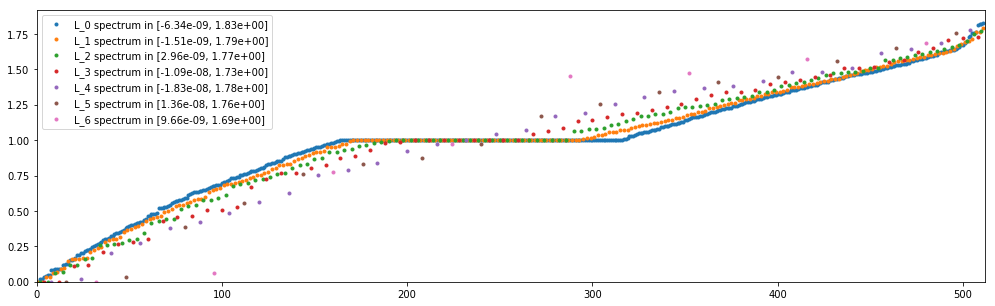

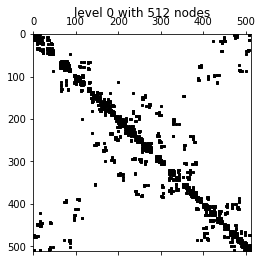

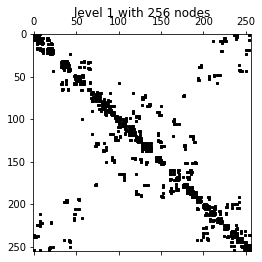

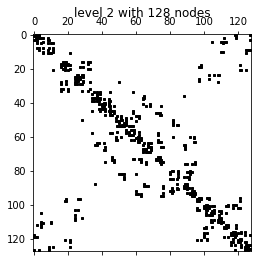

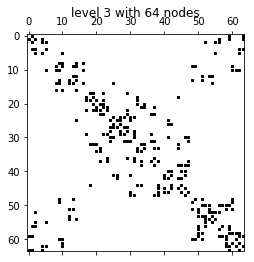

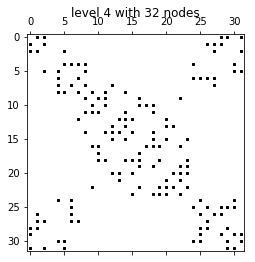

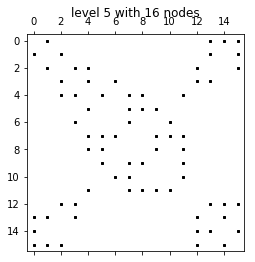

In [7]:
from scipy import sparse
noise_level = 0.001
coarsening_levels = 6
adjacent_mat_type = 'surface'
adjacent_mat_file = pathout + 'MMP_adjacency_mat_white.pconn.nii'

###loading adjcent matrix
adj_mat = nib.load(adjacent_mat_file).get_data()
adj_mat = sparse.csr_matrix(adj_mat)
print(adj_mat.shape)
A = graph.replace_random_edges(adj_mat, noise_level)
###build multi-level graph using coarsen (div by 2 at each level)
graphs, perm = coarsening.coarsen(A, levels=coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
# graph.plot_spectrum(L)

###build multi-level graph using coarsen (div by 2 at each level)
coarsening_levels = 6
graphs, perm = coarsening.coarsen(A, levels=coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

for li in range(coarsening_levels):
    plt.figure()
    plt.spy(graphs[li], markersize=2, color='black');
    plt.title('level %d with %d nodes' % (li,graphs[li].shape[0]))

In [10]:
import time
import tensorflow as tf

common = {}
common['dir_name']       = modality
common['num_epochs']     = 50 ###20
common['batch_size']     = 128
common['decay_steps']    = X_train[0].shape[0] / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = len(np.unique(Y_test)) + 1  # number of classes


model_perf = utils.model_perf()
dir(model_perf)

#print(model_perf.test_accuracy,model_perf.test_f1,model_perf.test_loss)
#print(model_perf.train_accuracy,model_perf.train_f1,model_perf.train_loss)

def show_gcn_results(s, fontsize=None):
    if fontsize:
        plt.rc('pdf', fonttype=42)
        plt.rc('ps', fonttype=42)
        plt.rc('font', size=fontsize)         # controls default text sizes
        plt.rc('axes', titlesize=fontsize)    # fontsize of the axes title
        plt.rc('axes', labelsize=fontsize)    # fontsize of the x any y labels
        plt.rc('xtick', labelsize=fontsize)   # fontsize of the tick labels
        plt.rc('ytick', labelsize=fontsize)   # fontsize of the tick labels
        plt.rc('legend', fontsize=fontsize)   # legend fontsize
        plt.rc('figure', titlesize=fontsize)  # size of the figure title
    print('  accuracy        F1             loss        time [ms]  name')
    print('test  train   test  train   test     train')
    for name in sorted(s.names):
        print('{:5.2f} {:5.2f}   {:5.2f} {:5.2f}   {:.2e} {:.2e}   {:3.0f}   {}'.format(
                s.test_accuracy[name], s.train_accuracy[name],
                s.test_f1[name], s.train_f1[name],
                s.test_loss[name], s.train_loss[name], s.fit_time[name]*1000, name))
    '''
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for name in sorted(s.names):
        steps = np.arange(len(s.fit_accuracies[name])) + 1
        steps *= s.params[name]['eval_frequency']
        ax[0].plot(steps, s.fit_accuracies[name], '.-', label=name)
        ax[1].plot(steps, s.fit_losses[name], '.-', label=name)
    ax[0].set_xlim(min(steps), max(steps))
    ax[1].set_xlim(min(steps), max(steps))
    ax[0].set_xlabel('step')
    ax[1].set_xlabel('step')
    ax[0].set_ylabel('validation accuracy')
    ax[1].set_ylabel('training loss')
    ax[0].legend(loc='lower right')
    ax[1].legend(loc='upper right')
    #fig.savefig('training.pdf')
    '''


In [16]:
###test different param settins
##model1: no convolution
name = 'softmax'
params = common.copy()
params['dir_name'] += name
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 0.02
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [C]
model = models.cgcnn(L, **params)
print(model)

d = {k: v+1 for v, k in enumerate(sorted(set(Y_test)))}
test_labels = np.array([d[x] for x in Y_test])
print(np.unique(Y_test))

train_acc = []; train_loss = [];
test_acc = []; test_loss = [];
val_acc = []; val_loss = [];
accuracy = []; loss = []; t_step = [];
for x_train, y_train, x_val, y_val,tcount in zip(X_train, Y_train, X_val, Y_val,range(2)):
    x_train = x_train.repeat()
    train_data = coarsening.perm_data(x_train.reshape(-1,Region_Num), perm)
    print(train_data.shape, x_train.shape, x_train.reshape(-1,Region_Num).shape)
    train_labels = np.array([d[x] for x in y_train])
    val_data = coarsening.perm_data(x_val.reshape(-1,Region_Num), perm)
    val_labels = np.array([d[x] for x in y_val])
    test_data = coarsening.perm_data(X_test.reshape(-1,Region_Num), perm)
    print('\nFold #%d: training on %d samples with %d features, validating on %d samples and testing on %d samples' % 
          (tcount+1,train_data.shape[0],train_data.shape[1],val_data.shape[0],test_data.shape[0]))  
    
    ###training
    model = models.cgcnn(L, **params)
    acc, los, tstep = model.fit(train_data, train_labels, val_data, val_labels)
    accuracy.append(acc)
    loss.append(los)
    t_step.append(tstep)

    ##evaluation
    model_perf.test(model, name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)
    train_acc.append(model_perf.train_accuracy[name])
    train_loss.append(model_perf.train_loss[name])
    test_acc.append(model_perf.test_accuracy[name])
    test_loss.append(model_perf.test_loss[name])
    val_acc.append(model_perf.fit_accuracies[name])
    val_loss.append(model_perf.fit_losses[name])
    print('\n')
       
print('Accuracy of training:{},testing:{}'.format(np.mean(train_acc),np.mean(test_acc)))
print('Accuracy of validation:',np.max(val_acc,axis=1))
print(' mean=%2f' % np.mean(np.max(val_acc,axis=1)))

show_gcn_results(model_perf,fontsize=50)
'''
###training figures
print(accuracy, loss,t_step )
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.mean(accuracy,axis=0), 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(np.mean(loss,axis=0), 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()
'''

NN architecture
  input: M_0 = 512
  layer 1: logits (softmax)
    representation: M_1 = 9
    weights: M_0 * M_1 = 512 * 9 = 4608
    biases: M_1 = 9
['body0b_wm' 'body2b_wm' 'face0b_wm' 'face2b_wm' 'place0b_wm' 'place2b_wm'
 'tool0b_wm' 'tool2b_wm']
(576, 360) (64, 360)
(576, 512) (576, 360) (576, 360)

Fold #1: training on 576 samples with 512 features, validating on 64 samples and testing on 160 samples
NN architecture
  input: M_0 = 512
  layer 1: logits (softmax)
    representation: M_1 = 9
    weights: M_0 * M_1 = 512 * 9 = 4608
    biases: M_1 = 9


step 225 / 225 (epoch 50.00 / 50):
  learning_rate = 1.62e-03, loss_average = 1.05e-01
  validation accuracy: 89.06 (57 / 64), f1 (weighted): 89.04, loss: 2.90e+00
  time: 0s (wall 0s)
validation accuracy: peak = 89.06, mean = 89.06


step 225 / 225 (epoch 50.00 / 50):
  learning_rate = 1.62e-03, loss_average = 1.05e-01
  validation accuracy: 89.06 (57 / 64), f1 (weighted): 89.00, loss: 2.96e+00
  time: 0s (wall 0s)
validation accuracy: peak = 89.06, mean = 89.06
INFO:tensorflow:Restoring parameters from /home/yu/PycharmProjects/HCP_fmripredict/cnn_graph/lib/../checkpoints/WMsoftmax/model-225


train accuracy: 99.48 (573 / 576), f1 (weighted): 99.48, loss: 3.80e-01
time: 0s (wall 0s)
INFO:tensorflow:Restoring parameters from /home/yu/PycharmProjects/HCP_fmripredict/cnn_graph/lib/../checkpoints/WMsoftmax/model-225


test  accuracy: 82.50 (132 / 160), f1 (weighted): 82.14, loss: 2.13e+00
time: 0s (wall 0s)


(576, 360) (64, 360)
(576, 512) (576, 360) (576, 360)

Fold #2: training on 576 samples with 512 features, validating on 64 samples and testing on 160 samples
NN architecture
  input: M_0 = 512
  layer 1: logits (softmax)
    representation: M_1 = 9
    weights: M_0 * M_1 = 512 * 9 = 4608
    biases: M_1 = 9


step 225 / 225 (epoch 50.00 / 50):
  learning_rate = 1.62e-03, loss_average = 1.09e-01
  validation accuracy: 84.38 (54 / 64), f1 (weighted): 84.15, loss: 2.91e+00
  time: 0s (wall 0s)
validation accuracy: peak = 84.38, mean = 84.38


step 225 / 225 (epoch 50.00 / 50):
  learning_rate = 1.62e-03, loss_average = 1.06e-01
  validation accuracy: 84.38 (54 / 64), f1 (weighted): 83.42, loss: 2.88e+00
  time: 0s (wall 0s)
validation accuracy: peak = 84.38, mean = 84.38
INFO:tensorflow:Restoring parameters from /home/yu/PycharmProjects/HCP_fmripredict/cnn_graph/lib/../checkpoints/WMsoftmax/model-225


train accuracy: 99.65 (574 / 576), f1 (weighted): 99.65, loss: 3.81e-01
time: 0s (wall 0s)
INFO:tensorflow:Restoring parameters from /home/yu/PycharmProjects/HCP_fmripredict/cnn_graph/lib/../checkpoints/WMsoftmax/model-225


test  accuracy: 81.88 (131 / 160), f1 (weighted): 81.57, loss: 2.09e+00
time: 0s (wall 0s)


Accuracy of training:99.56597222222223,testing:82.1875
Accuracy of validation: [89.0625 84.375 ]
 mean=86.718750
  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
81.88 99.65   81.57 99.65   2.09e+00 3.81e-01     1   softmax


"\n###training figures\nprint(accuracy, loss,t_step )\nfig, ax1 = plt.subplots(figsize=(10, 5))\nax1.plot(np.mean(accuracy,axis=0), 'b.-')\nax1.set_ylabel('validation accuracy', color='b')\nax2 = ax1.twinx()\nax2.plot(np.mean(loss,axis=0), 'g.-')\nax2.set_ylabel('training loss', color='g')\nplt.show()\n"

In [10]:
# Common hyper-parameters for LeNet5-like networks (two convolutional layers).
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64, 128]  # Number of graph convolutional filters.
common['K']              = [25, 25, 25]  # Polynomial orders.
common['p']              = [4, 4, 4]    # Pooling sizes.
common['M']              = [256, C]  # Output dimensionality of fully connected layers.

##model#1: two convolutional layers with fourier transform as filters
name = 'fgconv_fgconv_fc_softmax' #  'Non-Param'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'fourier'
params['K'] = np.zeros(len(common['p']), dtype=int)
for pi,li in zip(common['p'],range(len(common['p']))):
    if pi == 2: 
        params['K'][li] = L[li].shape[0]
    if pi == 4:
        params['K'][li] = L[li*2].shape[0]
print(params['K'])    
#params['K'] = [L[0].shape[0], L[2].shape[0]]
print([L[li].shape for li in range(len(L))])
model = models.cgcnn(L, **params)
    
d = {k: v+1 for v, k in enumerate(sorted(set(Y_test)))}
test_labels = np.array([d[x] for x in Y_test])
print(np.unique(Y_test))

train_acc = []; train_loss = [];
test_acc = []; test_loss = [];
val_acc = []; val_loss = [];
accuracy = []; loss = []; t_step = [];
for x_train, y_train, x_val, y_val,tcount in zip(X_train, Y_train, X_val, Y_val,range(2)):
    
    train_data = coarsening.perm_data(x_train.reshape(-1,Region_Num), perm)
    train_labels = np.array([d[x] for x in y_train])
    val_data = coarsening.perm_data(x_val.reshape(-1,Region_Num), perm)
    val_labels = np.array([d[x] for x in y_val])
    test_data = coarsening.perm_data(X_test.reshape(-1,Region_Num), perm)
    print('\nFold #%d: training on %d samples with %d features, validating on %d samples and testing on %d samples' % 
          (tcount+1,train_data.shape[0],train_data.shape[1],val_data.shape[0],test_data.shape[0]))  
    
    ###training
    model = models.cgcnn(L, **params)
    acc, los, tstep = model.fit(train_data, train_labels, val_data, val_labels)
    accuracy.append(acc)
    loss.append(los)
    t_step.append(tstep)

    ##evaluation
    model_perf.test(model, name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)
    train_acc.append(model_perf.train_accuracy[name])
    train_loss.append(model_perf.train_loss[name])
    test_acc.append(model_perf.test_accuracy[name])
    test_loss.append(model_perf.test_loss[name])
    val_acc.append(model_perf.fit_accuracies[name])
    val_loss.append(model_perf.fit_losses[name])
    print('\n')
       
print('Accuracy of training:{},testing:{}'.format(np.mean(train_acc),np.mean(test_acc)))
print('Accuracy of validation:',np.max(val_acc,axis=1))
print(' mean=%2f' % np.mean(np.max(val_acc,axis=1)))

###training figures
print(accuracy, loss,t_step )
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.mean(accuracy,axis=0), 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(np.mean(loss,axis=0), 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

###summarize the results
#model_perf.show()
show_gcn_results(model_perf)

[512 128  32]
[(512, 512), (256, 256), (128, 128), (64, 64), (32, 32), (16, 16), (8, 8)]
NN architecture
  input: M_0 = 512
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 512 * 32 / 4 = 4096
    weights: F_0 * F_1 * K_1 = 1 * 32 * 512 = 16384
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 128 * 64 / 4 = 2048
    weights: F_1 * F_2 * K_2 = 32 * 64 * 128 = 262144
    biases: F_2 = 64
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 32 * 128 / 4 = 1024
    weights: F_2 * F_3 * K_3 = 64 * 128 * 32 = 262144
    biases: F_3 = 128
  layer 4: fc1
    representation: M_4 = 256
    weights: M_3 * M_4 = 1024 * 256 = 262144
    biases: M_4 = 256
  layer 5: logits (softmax)
    representation: M_5 = 9
    weights: M_4 * M_5 = 256 * 9 = 2304
    biases: M_5 = 9


['body0b_wm' 'body2b_wm' 'face0b_wm' 'face2b_wm' 'place0b_wm' 'place2b_wm'
 'tool0b_wm' 'tool2b_wm']

Fold #1: training on 576 samples with 512 features, validating on 64 samples and testing on 160 samples
NN architecture
  input: M_0 = 512
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 512 * 32 / 4 = 4096
    weights: F_0 * F_1 * K_1 = 1 * 32 * 512 = 16384
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 128 * 64 / 4 = 2048
    weights: F_1 * F_2 * K_2 = 32 * 64 * 128 = 262144
    biases: F_2 = 64
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 32 * 128 / 4 = 1024
    weights: F_2 * F_3 * K_3 = 64 * 128 * 32 = 262144
    biases: F_3 = 128
  layer 4: fc1
    representation: M_4 = 256
    weights: M_3 * M_4 = 1024 * 256 = 262144
    biases: M_4 = 256
  layer 5: logits (softmax)
    representation: M_5 = 9
    weights: M_4 * M_5 = 256 * 9 = 2304
    biases: M_5 = 9


InternalError: cudnn PoolForward launch failed
	 [[node conv1/pooling/MaxPool (defined at /home/yu/PycharmProjects/HCP_fmripredict/cnn_graph/lib/models.py:937)  = MaxPool[T=DT_FLOAT, data_format="NCHW", ksize=[1, 1, 4, 1], padding="SAME", strides=[1, 1, 4, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/gradients/conv1/pooling/MaxPool_grad/MaxPoolGrad-0-TransposeNHWCToNCHW-LayoutOptimizer)]]
	 [[{{node training/control/_23}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_479_training/control", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'conv1/pooling/MaxPool', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-a6ac1547b405>", line 47, in <module>
    model = models.cgcnn(L, **params)
  File "/home/yu/PycharmProjects/HCP_fmripredict/cnn_graph/lib/models.py", line 812, in __init__
    self.build_graph(M_0)
  File "/home/yu/PycharmProjects/HCP_fmripredict/cnn_graph/lib/models.py", line 165, in build_graph
    op_logits = self.inference(self.ph_data, self.ph_dropout)
  File "/home/yu/PycharmProjects/HCP_fmripredict/cnn_graph/lib/models.py", line 194, in inference
    logits = self._inference(data, dropout)
  File "/home/yu/PycharmProjects/HCP_fmripredict/cnn_graph/lib/models.py", line 970, in _inference
    x = self.pool(x, self.p[i])
  File "/home/yu/PycharmProjects/HCP_fmripredict/cnn_graph/lib/models.py", line 937, in mpool1
    x = tf.nn.max_pool(x, ksize=[1,p,1,1], strides=[1,p,1,1], padding='SAME')
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 2140, in max_pool
    name=name)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 4641, in max_pool
    data_format=data_format, name=name)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/yu/tensorflow-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): cudnn PoolForward launch failed
	 [[node conv1/pooling/MaxPool (defined at /home/yu/PycharmProjects/HCP_fmripredict/cnn_graph/lib/models.py:937)  = MaxPool[T=DT_FLOAT, data_format="NCHW", ksize=[1, 1, 4, 1], padding="SAME", strides=[1, 1, 4, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/gradients/conv1/pooling/MaxPool_grad/MaxPoolGrad-0-TransposeNHWCToNCHW-LayoutOptimizer)]]
	 [[{{node training/control/_23}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_479_training/control", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


{'dir_name': 'WMsgconv_sgconv_fc_softmax', 'num_epochs': 50, 'batch_size': 128, 'decay_steps': 3768.375, 'eval_frequency': 1500, 'brelu': 'b1relu', 'pool': 'mpool1', 'regularization': 0.0005, 'dropout': 0.5, 'learning_rate': 0.02, 'decay_rate': 0.95, 'momentum': 0.9, 'F': [32, 64, 128], 'K': [25, 25, 25], 'p': [4, 4, 4], 'M': [256, 9], 'filter': 'spline'}
[(576, 576), (288, 288), (144, 144), (72, 72), (36, 36), (18, 18), (9, 9)]
NN architecture
  input: M_0 = 576
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 576 * 32 / 4 = 4608
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 144 * 64 / 4 = 2304
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 36 * 128 / 4 = 1152
    weights: F_2 * F_3 * K_3 = 64 * 128 * 25 = 204800
    biases: F_3 = 128
  layer 4: fc1
    representation: M_4 = 256
    weights: M_3 * M_4 = 1152 * 256 =

step 48000 / 188418 (epoch 12.74 / 50):
  learning_rate = 1.08e-02, loss_average = 9.74e-01
  validation accuracy: 61.38 (32937 / 53664), f1 (weighted): 61.32, loss: 1.15e+00
  time: 267s (wall 301s)
step 49500 / 188418 (epoch 13.14 / 50):
  learning_rate = 1.03e-02, loss_average = 9.93e-01
  validation accuracy: 61.26 (32873 / 53664), f1 (weighted): 61.27, loss: 1.15e+00
  time: 275s (wall 310s)
step 51000 / 188418 (epoch 13.53 / 50):
  learning_rate = 1.03e-02, loss_average = 9.93e-01
  validation accuracy: 61.42 (32961 / 53664), f1 (weighted): 61.46, loss: 1.15e+00
  time: 283s (wall 320s)
step 52500 / 188418 (epoch 13.93 / 50):
  learning_rate = 1.03e-02, loss_average = 1.02e+00
  validation accuracy: 61.47 (32989 / 53664), f1 (weighted): 61.39, loss: 1.15e+00
  time: 291s (wall 329s)
step 54000 / 188418 (epoch 14.33 / 50):
  learning_rate = 9.75e-03, loss_average = 1.00e+00
  validation accuracy: 61.57 (33043 / 53664), f1 (weighted): 61.56, loss: 1.15e+00
  time: 299s (wall 338s)


step 109500 / 188418 (epoch 29.06 / 50):
  learning_rate = 4.52e-03, loss_average = 8.39e-01
  validation accuracy: 61.79 (33158 / 53664), f1 (weighted): 61.82, loss: 1.17e+00
  time: 602s (wall 681s)
step 111000 / 188418 (epoch 29.46 / 50):
  learning_rate = 4.52e-03, loss_average = 8.94e-01
  validation accuracy: 61.96 (33250 / 53664), f1 (weighted): 62.00, loss: 1.16e+00
  time: 610s (wall 691s)
step 112500 / 188418 (epoch 29.85 / 50):
  learning_rate = 4.52e-03, loss_average = 8.48e-01
  validation accuracy: 62.05 (33297 / 53664), f1 (weighted): 62.07, loss: 1.17e+00
  time: 618s (wall 700s)
step 114000 / 188418 (epoch 30.25 / 50):
  learning_rate = 4.29e-03, loss_average = 9.05e-01
  validation accuracy: 61.91 (33222 / 53664), f1 (weighted): 61.94, loss: 1.16e+00
  time: 627s (wall 709s)
step 115500 / 188418 (epoch 30.65 / 50):
  learning_rate = 4.29e-03, loss_average = 8.81e-01
  validation accuracy: 62.31 (33436 / 53664), f1 (weighted): 62.33, loss: 1.15e+00
  time: 635s (wall 7

step 171000 / 188418 (epoch 45.38 / 50):
  learning_rate = 1.99e-03, loss_average = 7.94e-01
  validation accuracy: 61.85 (33191 / 53664), f1 (weighted): 61.88, loss: 1.19e+00
  time: 937s (wall 1061s)
step 172500 / 188418 (epoch 45.78 / 50):
  learning_rate = 1.99e-03, loss_average = 8.18e-01
  validation accuracy: 61.88 (33206 / 53664), f1 (weighted): 61.91, loss: 1.19e+00
  time: 945s (wall 1070s)
step 174000 / 188418 (epoch 46.17 / 50):
  learning_rate = 1.89e-03, loss_average = 7.68e-01
  validation accuracy: 61.84 (33185 / 53664), f1 (weighted): 61.87, loss: 1.20e+00
  time: 954s (wall 1080s)
step 175500 / 188418 (epoch 46.57 / 50):
  learning_rate = 1.89e-03, loss_average = 8.00e-01
  validation accuracy: 61.80 (33162 / 53664), f1 (weighted): 61.86, loss: 1.20e+00
  time: 962s (wall 1089s)
step 177000 / 188418 (epoch 46.97 / 50):
  learning_rate = 1.89e-03, loss_average = 8.44e-01
  validation accuracy: 61.86 (33197 / 53664), f1 (weighted): 61.89, loss: 1.18e+00
  time: 970s (wa

step 43500 / 188418 (epoch 11.54 / 50):
  learning_rate = 1.14e-02, loss_average = 1.03e+00
  validation accuracy: 61.16 (32820 / 53664), f1 (weighted): 61.17, loss: 1.15e+00
  time: 240s (wall 272s)
step 45000 / 188418 (epoch 11.94 / 50):
  learning_rate = 1.14e-02, loss_average = 1.06e+00
  validation accuracy: 61.49 (32996 / 53664), f1 (weighted): 61.48, loss: 1.15e+00
  time: 249s (wall 281s)
step 46500 / 188418 (epoch 12.34 / 50):
  learning_rate = 1.08e-02, loss_average = 1.01e+00
  validation accuracy: 61.18 (32833 / 53664), f1 (weighted): 61.13, loss: 1.15e+00
  time: 257s (wall 290s)
step 48000 / 188418 (epoch 12.74 / 50):
  learning_rate = 1.08e-02, loss_average = 9.95e-01
  validation accuracy: 61.36 (32929 / 53664), f1 (weighted): 61.37, loss: 1.14e+00
  time: 265s (wall 300s)
step 49500 / 188418 (epoch 13.14 / 50):
  learning_rate = 1.03e-02, loss_average = 1.00e+00
  validation accuracy: 61.47 (32987 / 53664), f1 (weighted): 61.46, loss: 1.15e+00
  time: 273s (wall 309s)


step 105000 / 188418 (epoch 27.86 / 50):
  learning_rate = 5.01e-03, loss_average = 8.71e-01
  validation accuracy: 61.90 (33220 / 53664), f1 (weighted): 61.91, loss: 1.15e+00
  time: 576s (wall 652s)
step 106500 / 188418 (epoch 28.26 / 50):
  learning_rate = 4.76e-03, loss_average = 8.46e-01
  validation accuracy: 61.91 (33226 / 53664), f1 (weighted): 61.92, loss: 1.15e+00
  time: 584s (wall 661s)
step 108000 / 188418 (epoch 28.66 / 50):
  learning_rate = 4.76e-03, loss_average = 8.80e-01
  validation accuracy: 62.10 (33325 / 53664), f1 (weighted): 62.12, loss: 1.15e+00
  time: 592s (wall 670s)
step 109500 / 188418 (epoch 29.06 / 50):
  learning_rate = 4.52e-03, loss_average = 8.49e-01
  validation accuracy: 62.05 (33297 / 53664), f1 (weighted): 62.03, loss: 1.16e+00
  time: 601s (wall 680s)
step 111000 / 188418 (epoch 29.46 / 50):
  learning_rate = 4.52e-03, loss_average = 8.91e-01
  validation accuracy: 62.00 (33274 / 53664), f1 (weighted): 62.00, loss: 1.16e+00
  time: 609s (wall 6

step 166500 / 188418 (epoch 44.18 / 50):
  learning_rate = 2.09e-03, loss_average = 8.01e-01
  validation accuracy: 62.05 (33297 / 53664), f1 (weighted): 62.04, loss: 1.19e+00
  time: 911s (wall 1031s)
step 168000 / 188418 (epoch 44.58 / 50):
  learning_rate = 2.09e-03, loss_average = 8.12e-01
  validation accuracy: 62.22 (33389 / 53664), f1 (weighted): 62.22, loss: 1.18e+00
  time: 919s (wall 1041s)
step 169500 / 188418 (epoch 44.98 / 50):
  learning_rate = 2.09e-03, loss_average = 7.61e-01
  validation accuracy: 62.13 (33341 / 53664), f1 (weighted): 62.16, loss: 1.19e+00
  time: 927s (wall 1050s)
step 171000 / 188418 (epoch 45.38 / 50):
  learning_rate = 1.99e-03, loss_average = 7.98e-01
  validation accuracy: 61.95 (33243 / 53664), f1 (weighted): 61.94, loss: 1.19e+00
  time: 935s (wall 1059s)
step 172500 / 188418 (epoch 45.78 / 50):
  learning_rate = 1.99e-03, loss_average = 8.31e-01
  validation accuracy: 62.16 (33356 / 53664), f1 (weighted): 62.15, loss: 1.18e+00
  time: 943s (wa

/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 17.21 (9233 / 53664), f1 (weighted): 12.35, loss: 2.49e+00
  time: 9s (wall 10s)
step 3000 / 188418 (epoch 0.80 / 50):
  learning_rate = 2.00e-02, loss_average = 1.97e+00
  validation accuracy: 41.89 (22479 / 53664), f1 (weighted): 40.82, loss: 1.94e+00
  time: 17s (wall 20s)
step 4500 / 188418 (epoch 1.19 / 50):
  learning_rate = 1.90e-02, loss_average = 1.72e+00
  validation accuracy: 48.19 (25861 / 53664), f1 (weighted): 48.29, loss: 1.69e+00
  time: 26s (wall 29s)
step 6000 / 188418 (epoch 1.59 / 50):
  learning_rate = 1.90e-02, loss_average = 1.60e+00
  validation accuracy: 52.16 (27989 / 53664), f1 (weighted): 51.98, loss: 1.54e+00
  time: 34s (wall 39s)
step 7500 / 188418 (epoch 1.99 / 50):
  learning_rate = 1.90e-02, loss_average = 1.49e+00
  validation accuracy: 54.78 (29397 / 53664), f1 (weighted): 54.93, loss: 1.44e+00
  time: 43s (wall 48s)
step 9000 / 188418 (epoch 2.39 / 50):
  learning_rate = 1.80e-02, loss_average = 1.39e+00
  validation accuracy:

step 64500 / 188418 (epoch 17.12 / 50):
  learning_rate = 8.36e-03, loss_average = 9.33e-01
  validation accuracy: 62.08 (33315 / 53664), f1 (weighted): 62.08, loss: 1.13e+00
  time: 350s (wall 398s)
step 66000 / 188418 (epoch 17.51 / 50):
  learning_rate = 8.36e-03, loss_average = 9.35e-01
  validation accuracy: 62.34 (33455 / 53664), f1 (weighted): 62.37, loss: 1.13e+00
  time: 358s (wall 407s)
step 67500 / 188418 (epoch 17.91 / 50):
  learning_rate = 8.36e-03, loss_average = 9.58e-01
  validation accuracy: 62.17 (33363 / 53664), f1 (weighted): 62.24, loss: 1.13e+00
  time: 366s (wall 416s)
step 69000 / 188418 (epoch 18.31 / 50):
  learning_rate = 7.94e-03, loss_average = 9.56e-01
  validation accuracy: 62.32 (33445 / 53664), f1 (weighted): 62.34, loss: 1.13e+00
  time: 375s (wall 426s)
step 70500 / 188418 (epoch 18.71 / 50):
  learning_rate = 7.94e-03, loss_average = 9.82e-01
  validation accuracy: 62.15 (33351 / 53664), f1 (weighted): 62.17, loss: 1.13e+00
  time: 382s (wall 435s)


step 126000 / 188418 (epoch 33.44 / 50):
  learning_rate = 3.68e-03, loss_average = 8.33e-01
  validation accuracy: 62.62 (33605 / 53664), f1 (weighted): 62.66, loss: 1.15e+00
  time: 681s (wall 775s)
step 127500 / 188418 (epoch 33.83 / 50):
  learning_rate = 3.68e-03, loss_average = 8.74e-01
  validation accuracy: 62.83 (33717 / 53664), f1 (weighted): 62.82, loss: 1.15e+00
  time: 690s (wall 784s)
step 129000 / 188418 (epoch 34.23 / 50):
  learning_rate = 3.50e-03, loss_average = 8.63e-01
  validation accuracy: 62.82 (33714 / 53664), f1 (weighted): 62.85, loss: 1.15e+00
  time: 698s (wall 793s)
step 130500 / 188418 (epoch 34.63 / 50):
  learning_rate = 3.50e-03, loss_average = 8.43e-01
  validation accuracy: 62.69 (33641 / 53664), f1 (weighted): 62.72, loss: 1.15e+00
  time: 706s (wall 803s)
step 132000 / 188418 (epoch 35.03 / 50):
  learning_rate = 3.32e-03, loss_average = 8.58e-01
  validation accuracy: 62.58 (33585 / 53664), f1 (weighted): 62.59, loss: 1.16e+00
  time: 714s (wall 8

step 187500 / 188418 (epoch 49.76 / 50):
  learning_rate = 1.62e-03, loss_average = 7.86e-01
  validation accuracy: 62.67 (33632 / 53664), f1 (weighted): 62.67, loss: 1.18e+00
  time: 1013s (wall 1152s)
step 188418 / 188418 (epoch 50.00 / 50):
  learning_rate = 1.62e-03, loss_average = 7.75e-01
  validation accuracy: 62.55 (33566 / 53664), f1 (weighted): 62.57, loss: 1.18e+00
  time: 1019s (wall 1158s)
validation accuracy: peak = 62.93, mean = 62.55
step 1500 / 188418 (epoch 0.40 / 50):
  learning_rate = 2.00e-02, loss_average = 2.43e+00
  validation accuracy: 22.75 (12209 / 53664), f1 (weighted): 17.33, loss: 2.43e+00
  time: 9s (wall 10s)
step 3000 / 188418 (epoch 0.80 / 50):
  learning_rate = 2.00e-02, loss_average = 1.94e+00
  validation accuracy: 44.78 (24030 / 53664), f1 (weighted): 44.39, loss: 1.87e+00
  time: 18s (wall 20s)
step 4500 / 188418 (epoch 1.19 / 50):
  learning_rate = 1.90e-02, loss_average = 1.70e+00
  validation accuracy: 49.98 (26823 / 53664), f1 (weighted): 50.1

step 60000 / 188418 (epoch 15.92 / 50):
  learning_rate = 9.27e-03, loss_average = 9.87e-01
  validation accuracy: 62.39 (33483 / 53664), f1 (weighted): 62.39, loss: 1.13e+00
  time: 328s (wall 371s)
step 61500 / 188418 (epoch 16.32 / 50):
  learning_rate = 8.80e-03, loss_average = 9.66e-01
  validation accuracy: 62.32 (33441 / 53664), f1 (weighted): 62.32, loss: 1.13e+00
  time: 336s (wall 380s)
step 63000 / 188418 (epoch 16.72 / 50):
  learning_rate = 8.80e-03, loss_average = 9.51e-01
  validation accuracy: 62.44 (33509 / 53664), f1 (weighted): 62.45, loss: 1.13e+00
  time: 344s (wall 389s)
step 64500 / 188418 (epoch 17.12 / 50):
  learning_rate = 8.36e-03, loss_average = 9.62e-01
  validation accuracy: 62.36 (33467 / 53664), f1 (weighted): 62.35, loss: 1.14e+00
  time: 352s (wall 399s)
step 66000 / 188418 (epoch 17.51 / 50):
  learning_rate = 8.36e-03, loss_average = 9.69e-01
  validation accuracy: 62.65 (33618 / 53664), f1 (weighted): 62.66, loss: 1.13e+00
  time: 360s (wall 408s)


step 121500 / 188418 (epoch 32.24 / 50):
  learning_rate = 3.87e-03, loss_average = 8.68e-01
  validation accuracy: 62.44 (33506 / 53664), f1 (weighted): 62.39, loss: 1.15e+00
  time: 659s (wall 748s)
step 123000 / 188418 (epoch 32.64 / 50):
  learning_rate = 3.87e-03, loss_average = 8.65e-01
  validation accuracy: 62.36 (33465 / 53664), f1 (weighted): 62.36, loss: 1.15e+00
  time: 667s (wall 757s)
step 124500 / 188418 (epoch 33.04 / 50):
  learning_rate = 3.68e-03, loss_average = 8.42e-01
  validation accuracy: 62.51 (33547 / 53664), f1 (weighted): 62.54, loss: 1.16e+00
  time: 675s (wall 766s)
step 126000 / 188418 (epoch 33.44 / 50):
  learning_rate = 3.68e-03, loss_average = 8.45e-01
  validation accuracy: 62.29 (33426 / 53664), f1 (weighted): 62.30, loss: 1.17e+00
  time: 683s (wall 775s)
step 127500 / 188418 (epoch 33.83 / 50):
  learning_rate = 3.68e-03, loss_average = 8.44e-01
  validation accuracy: 62.24 (33400 / 53664), f1 (weighted): 62.18, loss: 1.16e+00
  time: 691s (wall 7

step 183000 / 188418 (epoch 48.56 / 50):
  learning_rate = 1.71e-03, loss_average = 8.09e-01
  validation accuracy: 62.30 (33435 / 53664), f1 (weighted): 62.31, loss: 1.18e+00
  time: 991s (wall 1124s)
step 184500 / 188418 (epoch 48.96 / 50):
  learning_rate = 1.71e-03, loss_average = 7.79e-01
  validation accuracy: 62.18 (33370 / 53664), f1 (weighted): 62.14, loss: 1.19e+00
  time: 999s (wall 1134s)
step 186000 / 188418 (epoch 49.36 / 50):
  learning_rate = 1.62e-03, loss_average = 7.98e-01
  validation accuracy: 62.21 (33384 / 53664), f1 (weighted): 62.24, loss: 1.18e+00
  time: 1007s (wall 1143s)
step 187500 / 188418 (epoch 49.76 / 50):
  learning_rate = 1.62e-03, loss_average = 8.12e-01
  validation accuracy: 62.06 (33305 / 53664), f1 (weighted): 62.03, loss: 1.19e+00
  time: 1015s (wall 1152s)
step 188418 / 188418 (epoch 50.00 / 50):
  learning_rate = 1.62e-03, loss_average = 7.95e-01
  validation accuracy: 62.12 (33338 / 53664), f1 (weighted): 62.12, loss: 1.19e+00
  time: 1021s 

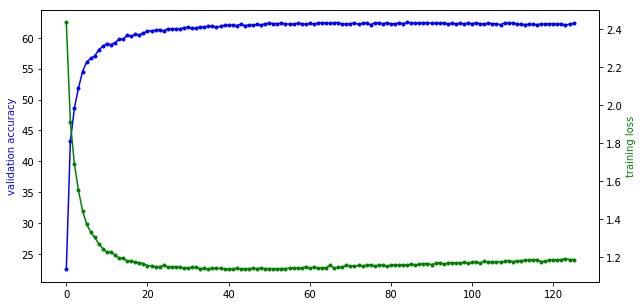

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
62.28 76.67   62.28 76.66   1.18e+00 7.31e-01     6   sgconv_sgconv_fc_softmax


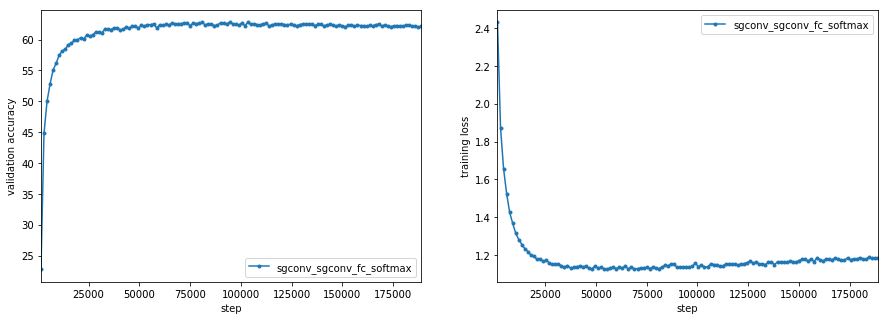

In [39]:
# Common hyper-parameters for LeNet5-like networks (two convolutional layers).
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64, 128]  # Number of graph convolutional filters.
common['K']              = [25, 25, 25]  # Polynomial orders.
common['p']              = [4, 4, 4]    # Pooling sizes.
common['M']              = [256, C]  # Output dimensionality of fully connected layers.

##model#2: two convolutional layers with spline basis as filters
name = 'sgconv_sgconv_fc_softmax' #  'Non-Param'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'spline'
print(params)    
print([L[li].shape for li in range(len(L))])
model = models.cgcnn(L, **params)
    
d = {k: v+1 for v, k in enumerate(sorted(set(Y_test)))}
test_labels = np.array([d[x] for x in Y_test])
print(np.unique(Y_test))

train_acc = []; train_loss = [];
test_acc = []; test_loss = [];
val_acc = []; val_loss = [];
accuracy = []; loss = []; t_step = [];
for x_train, y_train, x_val, y_val,tcount in zip(X_train, Y_train, X_val, Y_val,range(2)):
    
    train_data = coarsening.perm_data(x_train.reshape(-1,Region_Num), perm)
    train_labels = np.array([d[x] for x in y_train])
    val_data = coarsening.perm_data(x_val.reshape(-1,Region_Num), perm)
    val_labels = np.array([d[x] for x in y_val])
    test_data = coarsening.perm_data(X_test.reshape(-1,Region_Num), perm)
    print('\nFold #%d: training on %d samples with %d features, validating on %d samples and testing on %d samples' % 
          (tcount+1,train_data.shape[0],train_data.shape[1],val_data.shape[0],test_data.shape[0]))  
    
    ###training
    model = models.cgcnn(L, **params)
    acc, los, tstep = model.fit(train_data, train_labels, val_data, val_labels)
    accuracy.append(acc)
    loss.append(los)
    t_step.append(tstep)

    ##evaluation
    model_perf.test(model, name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)
    train_acc.append(model_perf.train_accuracy[name])
    train_loss.append(model_perf.train_loss[name])
    test_acc.append(model_perf.test_accuracy[name])
    test_loss.append(model_perf.test_loss[name])
    val_acc.append(model_perf.fit_accuracies[name])
    val_loss.append(model_perf.fit_losses[name])
    print('\n')
       
print('Accuracy of training:{},testing:{}'.format(np.mean(train_acc),np.mean(test_acc)))
print('Accuracy of validation:',np.max(val_acc,axis=1))
print(' mean=%2f' % np.mean(np.max(val_acc,axis=1)))

###training figures
print(accuracy, loss,t_step )
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.mean(accuracy,axis=0), 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(np.mean(loss,axis=0), 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

###summarize the results
model_perf.show()

In [ ]:
# Common hyper-parameters for LeNet5-like networks (two convolutional layers).
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.005  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.9 ##0.95
common['momentum']       = 0.9
common['F']              = [32, 64, 128]  # Number of graph convolutional filters.
common['K']              = [ 25,25,25]  # Polynomial orders.
common['p']              = [4,4,4]    # Pooling sizes.
common['M']              = [256, C]  # Output dimensionality of fully connected layers.

##model#3: two convolutional layers with Chebyshev polynomial as filters
name = 'cgconv_cgconv_fc_softmax' #  'Non-Param'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'chebyshev5'
print(params)    
print([L[li].shape for li in range(len(L))])
model = models.cgcnn(L, **params)
    
d = {k: v+1 for v, k in enumerate(sorted(set(Y_test)))}
test_labels = np.array([d[x] for x in Y_test])
print(np.unique(Y_test))

train_acc = []; train_loss = [];
test_acc = []; test_loss = [];
val_acc = []; val_loss = [];
accuracy = []; loss = []; t_step = [];
for x_train, y_train, x_val, y_val,tcount in zip(X_train, Y_train, X_val, Y_val,range(2)):
    
    train_data = coarsening.perm_data(x_train.reshape(-1,Region_Num), perm)
    train_labels = np.array([d[x] for x in y_train])
    val_data = coarsening.perm_data(x_val.reshape(-1,Region_Num), perm)
    val_labels = np.array([d[x] for x in y_val])
    test_data = coarsening.perm_data(X_test.reshape(-1,Region_Num), perm)
    print('\nFold #%d: training on %d samples with %d features, validating on %d samples and testing on %d samples' % 
          (tcount+1,train_data.shape[0],train_data.shape[1],val_data.shape[0],test_data.shape[0]))  
    
    ###training
    acc, los, tstep = model.fit(train_data, train_labels, val_data, val_labels)
    accuracy.append(acc)
    loss.append(los)
    t_step.append(tstep)

    ##evaluation
    model_perf.test(model, name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)
    train_acc.append(model_perf.train_accuracy[name])
    train_loss.append(model_perf.train_loss[name])
    test_acc.append(model_perf.test_accuracy[name])
    test_loss.append(model_perf.test_loss[name])
    val_acc.append(model_perf.fit_accuracies[name])
    val_loss.append(model_perf.fit_losses[name])
    print('\n')
       
print('Accuracy of training:{},testing:{}'.format(np.mean(train_acc),np.mean(test_acc)))
print('Accuracy of validation:',np.max(val_acc,axis=1))
print(' mean=%2f' % np.mean(np.max(val_acc,axis=1)))

###training figures
print(accuracy, loss,t_step )
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.mean(accuracy,axis=0), 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(np.mean(loss,axis=0), 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

###summarize the results
model_perf.show()

{'dir_name': 'WMcgconv_cgconv_fc_softmax', 'num_epochs': 50, 'batch_size': 128, 'decay_steps': 3768.375, 'eval_frequency': 1500, 'brelu': 'b1relu', 'pool': 'mpool1', 'regularization': 0.0005, 'dropout': 0.5, 'learning_rate': 0.005, 'decay_rate': 0.9, 'momentum': 0.9, 'F': [32, 64, 128], 'K': [25, 25, 25], 'p': [4, 4, 4], 'M': [256, 9], 'filter': 'chebyshev5'}
[(512, 512), (256, 256), (128, 128), (64, 64), (32, 32), (16, 16), (8, 8)]
NN architecture
  input: M_0 = 512
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 512 * 32 / 4 = 4096
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 128 * 64 / 4 = 2048
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 32 * 128 / 4 = 1024
    weights: F_2 * F_3 * K_3 = 64 * 128 * 25 = 204800
    biases: F_3 = 128
  layer 4: fc1
    representation: M_4 = 256
    weights: M_3 * M_4 = 1024 * 2

  validation accuracy: 57.60 (30911 / 53664), f1 (weighted): 57.61, loss: 1.33e+00
  time: 1197s (wall 2316s)
step 54000 / 188418 (epoch 14.33 / 50):
  learning_rate = 1.14e-03, loss_average = 1.28e+00
  validation accuracy: 57.67 (30950 / 53664), f1 (weighted): 57.65, loss: 1.32e+00
  time: 1231s (wall 2382s)
step 55500 / 188418 (epoch 14.73 / 50):
  learning_rate = 1.14e-03, loss_average = 1.34e+00
  validation accuracy: 57.60 (30912 / 53664), f1 (weighted): 57.60, loss: 1.32e+00
  time: 1265s (wall 2448s)
step 57000 / 188418 (epoch 15.13 / 50):
  learning_rate = 1.03e-03, loss_average = 1.29e+00
  validation accuracy: 57.75 (30991 / 53664), f1 (weighted): 57.81, loss: 1.31e+00
  time: 1299s (wall 2514s)
step 58500 / 188418 (epoch 15.52 / 50):
  learning_rate = 1.03e-03, loss_average = 1.22e+00
  validation accuracy: 57.72 (30977 / 53664), f1 (weighted): 57.77, loss: 1.31e+00
  time: 1332s (wall 2580s)
step 60000 / 188418 (epoch 15.92 / 50):
  learning_rate = 1.03e-03, loss_average =

step 114000 / 188418 (epoch 30.25 / 50):
  learning_rate = 2.12e-04, loss_average = 1.22e+00
  validation accuracy: 58.70 (31503 / 53664), f1 (weighted): 58.75, loss: 1.26e+00
  time: 2584s (wall 5018s)
step 115500 / 188418 (epoch 30.65 / 50):
  learning_rate = 2.12e-04, loss_average = 1.21e+00
  validation accuracy: 58.80 (31557 / 53664), f1 (weighted): 58.81, loss: 1.26e+00
  time: 2618s (wall 5084s)
step 117000 / 188418 (epoch 31.05 / 50):
  learning_rate = 1.91e-04, loss_average = 1.20e+00
  validation accuracy: 58.81 (31562 / 53664), f1 (weighted): 58.83, loss: 1.26e+00
  time: 2652s (wall 5150s)
step 118500 / 188418 (epoch 31.45 / 50):
  learning_rate = 1.91e-04, loss_average = 1.18e+00
  validation accuracy: 58.94 (31627 / 53664), f1 (weighted): 58.95, loss: 1.26e+00
  time: 2686s (wall 5216s)
step 120000 / 188418 (epoch 31.84 / 50):
  learning_rate = 1.91e-04, loss_average = 1.20e+00
  validation accuracy: 58.98 (31653 / 53664), f1 (weighted): 59.00, loss: 1.26e+00
  time: 2720

  validation accuracy: 59.03 (31677 / 53664), f1 (weighted): 59.05, loss: 1.25e+00
  time: 3938s (wall 7654s)
step 175500 / 188418 (epoch 46.57 / 50):
  learning_rate = 3.93e-05, loss_average = 1.17e+00
  validation accuracy: 59.09 (31711 / 53664), f1 (weighted): 59.12, loss: 1.25e+00
  time: 3972s (wall 7720s)
step 177000 / 188418 (epoch 46.97 / 50):
  learning_rate = 3.93e-05, loss_average = 1.20e+00
  validation accuracy: 59.11 (31719 / 53664), f1 (weighted): 59.12, loss: 1.25e+00
  time: 4006s (wall 7786s)
step 178500 / 188418 (epoch 47.37 / 50):
  learning_rate = 3.53e-05, loss_average = 1.18e+00
  validation accuracy: 59.12 (31724 / 53664), f1 (weighted): 59.14, loss: 1.25e+00
  time: 4040s (wall 7851s)
step 180000 / 188418 (epoch 47.77 / 50):
  learning_rate = 3.53e-05, loss_average = 1.17e+00
  validation accuracy: 59.13 (31730 / 53664), f1 (weighted): 59.14, loss: 1.25e+00
  time: 4073s (wall 7917s)
step 181500 / 188418 (epoch 48.16 / 50):
  learning_rate = 3.18e-05, loss_aver

  validation accuracy: 57.90 (31074 / 53664), f1 (weighted): 57.91, loss: 1.32e+00
  time: 1056s (wall 2054s)
step 48000 / 188418 (epoch 12.74 / 50):
  learning_rate = 1.41e-03, loss_average = 1.29e+00
  validation accuracy: 57.82 (31031 / 53664), f1 (weighted): 57.86, loss: 1.31e+00
  time: 1090s (wall 2120s)
step 49500 / 188418 (epoch 13.14 / 50):
  learning_rate = 1.27e-03, loss_average = 1.26e+00
  validation accuracy: 57.99 (31119 / 53664), f1 (weighted): 57.94, loss: 1.31e+00
  time: 1124s (wall 2186s)


# 